# Bike Sharing Classification

In [1]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, plot_roc_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree, export_text
from sklearn.ensemble import AdaBoostClassifier
from warnings import filterwarnings

filterwarnings('ignore')

### Preprocessing

In [2]:
bike_df = pd.read_csv('../data/SeoulBikeData.csv', engine = 'python')

bike_df.columns = ['date', 'bike_count', 'hour', 'temperature', 'humidity', 'wind_speed', 'visibility', 'dew_point_temp', 
                   'solar_radiation', 'rainfall', 'snowfall', 'season', 'holiday', 'functioning_day']

bike_df['date'] = pd.to_datetime(bike_df['date'], format = '%d/%m/%Y')
bike_df['hour'] = bike_df['hour'].astype('category')
bike_df['season'] = bike_df['season'].astype('category')
bike_df['holiday'] = bike_df['holiday'].astype('category')
bike_df['functioning_day'] = bike_df['functioning_day'].astype('category')
bike_df['day'] = bike_df['date'].dt.day_name().astype('category')

bike_df = bike_df[bike_df['functioning_day'] == 'Yes']
bike_df = bike_df.drop(['date', 'functioning_day', 'dew_point_temp'], axis = 1)
bike_df = bike_df.reset_index(drop = True)

bike_df.head()

,bike_count,hour,temperature,humidity,wind_speed,visibility,solar_radiation,rainfall,snowfall,season,holiday,day
0,254,0,-5.2,37,2.2,2000,0.0,0.0,0.0,Winter,No Holiday,Friday
1,204,1,-5.5,38,0.8,2000,0.0,0.0,0.0,Winter,No Holiday,Friday
2,173,2,-6.0,39,1.0,2000,0.0,0.0,0.0,Winter,No Holiday,Friday
3,107,3,-6.2,40,0.9,2000,0.0,0.0,0.0,Winter,No Holiday,Friday
4,78,4,-6.0,36,2.3,2000,0.0,0.0,0.0,Winter,No Holiday,Friday


In [3]:
full_df = bike_df

full_ddf = pd.get_dummies(full_df['hour'], drop_first = True, prefix = 'hour:')
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['day'], drop_first = True, prefix = 'day:')], axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['season'], drop_first = True, prefix = 'season:')], axis = 1)
full_ddf = pd.concat([full_ddf, pd.get_dummies(full_df['holiday'],  prefix = 'holiday:')], axis = 1)
full_ddf = full_ddf.drop('holiday:_No Holiday', axis = 1)

full_df = full_df.drop(['hour', 'day', 'season', 'holiday'], axis = 1)

y = pd.DataFrame(full_df['bike_count']).reset_index(drop = True)
c = y > np.median(y)

full_df = full_df.drop('bike_count', axis = 1)

def featureNormalize(X):
    return (X - np.mean(X, axis = 0)) / np.std(X, axis = 0, ddof = 1)

X1 = pd.concat([featureNormalize(full_df), full_ddf], axis = 1).reset_index(drop = True)
X2 = pd.concat([full_df, full_ddf], axis = 1).reset_index(drop = True)

In [4]:
X1_train = X1.sample(random_state = 42, frac = 0.7).sort_index()
X2_train = X2[X1.index.isin(X1_train.index)]
c_train = c[X1.index.isin(X1_train.index)]
X1_test = X1[~X1.index.isin(X1_train.index)]
X2_test = X2[~X1.index.isin(X1_train.index)]
c_test = c[~X1.index.isin(X1_train.index)]

### Support Vector Classification using Linear Kernel

In [5]:
lsvc_reg_arr = np.logspace(-5, 2, 8)

lsvc = GridSearchCV(SVC(random_state = 42, kernel = 'linear'), 
                    param_grid = {'C' : lsvc_reg_arr}, 
                    cv = 5, return_train_score = True)

lsvc.fit(X1_train.values, c_train.values.ravel())

lsvc_df = pd.DataFrame(lsvc.cv_results_)

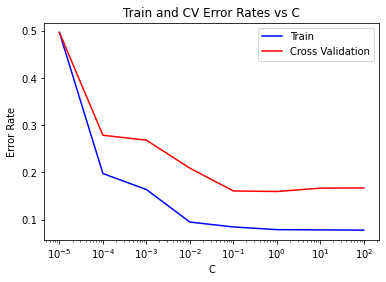

In [6]:
plt.plot(lsvc_df['param_C'], 1 - lsvc_df['mean_train_score'], c = 'b', label = 'Train')
plt.plot(lsvc_df['param_C'], 1 - lsvc_df['mean_test_score'], c = 'r', label = 'Cross Validation')
plt.xscale('log')
plt.legend(loc = 1)
plt.xlabel('C')
plt.ylabel('Error Rate')
plt.title('Train and CV Error Rates vs C')
plt.show()

Best Parameters: {'C': 1.0}
Best Cross-Validation Accuracy: 0.84


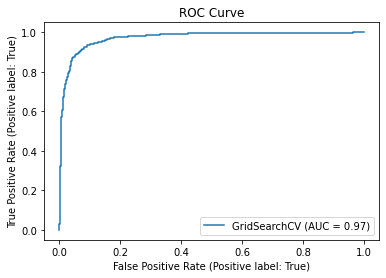

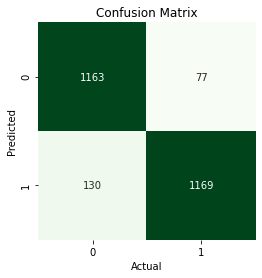

Accuracy: 0.92
Sensitivity: 0.94
Specificity: 0.90


In [7]:
print('Best Parameters: {}'.format(lsvc.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(lsvc.best_score_))

pred_lsvc = lsvc.predict(X1_test)

plot_roc_curve(lsvc, X1_test, c_test)
plt.title('ROC Curve')
plt.show()

cm_lsvc = confusion_matrix(c_test, pred_lsvc)
tn, fp, fn, tp = cm_lsvc.ravel()

ax = sns.heatmap(cm_lsvc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_lsvc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

### Support Vector Classification using Radial Kernel

In [8]:
rsvc_reg_arr = np.logspace(-2, 2, 5)
rsvc_gamma_arr = np.logspace(-3, 1, 5)

rsvc = GridSearchCV(SVC(random_state = 42, kernel = 'rbf'), 
                    param_grid = {'C' : rsvc_reg_arr, 'gamma' : rsvc_gamma_arr}, 
                    cv = 5, return_train_score = True)

rsvc.fit(X1_train.values, c_train.values.ravel())

rsvc_df = pd.DataFrame(rsvc.cv_results_)

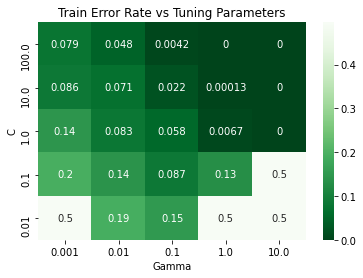

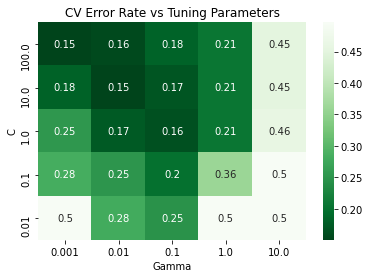

In [9]:
rsvc_train_err_mat = (1 - rsvc_df['mean_train_score']).values.reshape(len(rsvc_reg_arr), len(rsvc_gamma_arr))
ax = sns.heatmap(pd.DataFrame(rsvc_train_err_mat, columns = rsvc_gamma_arr, index = rsvc_reg_arr).iloc[::-1], 
                 annot = True, cmap = 'Greens_r')
ax.set(xlabel = 'Gamma', ylabel = 'C', title = 'Train Error Rate vs Tuning Parameters')
plt.show()

rsvc_cv_err_mat = (1 - rsvc_df['mean_test_score']).values.reshape(len(rsvc_reg_arr), len(rsvc_gamma_arr))
ax = sns.heatmap(pd.DataFrame(rsvc_cv_err_mat, columns = rsvc_gamma_arr, index = rsvc_reg_arr).iloc[::-1], 
                 annot = True, cmap = 'Greens_r')
ax.set(xlabel = 'Gamma', ylabel = 'C', title = 'CV Error Rate vs Tuning Parameters')
plt.show()

In [10]:
# fig = plt.figure(figsize = (6, 6))
# ax = fig.gca(projection = '3d')
# ax.plot_trisurf(np.log10(rsvc_df['param_C'].values.astype(float)), 
#                 np.log10(rsvc_df['param_gamma'].values.astype(float)), 
#                 1 - rsvc_df['mean_test_score'], cmap = plt.cm.viridis, linewidth = 0.2)
# ax.set(xlabel ='C', ylabel = 'Gamma', zlabel = 'CV Error Rate', title = 'CV Error Rate vs Tuning Parameters')
# ax.set_xticks(range(len(rsvc_reg_arr)))
# ax.set_xticklabels(rsvc_reg_arr)
# ax.set_yticks(range(len(rsvc_gamma_arr)))
# ax.set_yticklabels(rsvc_gamma_arr)
# plt.show()

Best Parameters: {'C': 10.0, 'gamma': 0.01}
Best Cross-Validation Accuracy: 0.85


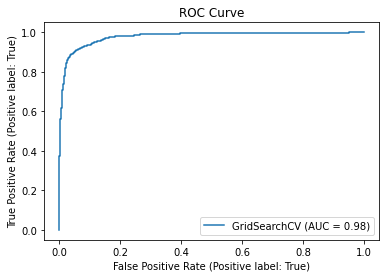

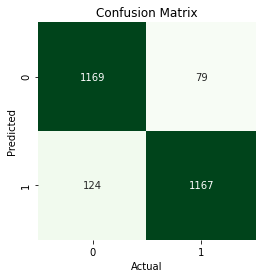

Accuracy: 0.92
Sensitivity: 0.94
Specificity: 0.90


In [11]:
print('Best Parameters: {}'.format(rsvc.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(rsvc.best_score_))

pred_rsvc = rsvc.predict(X1_test)

plot_roc_curve(rsvc, X1_test, c_test)
plt.title('ROC Curve')
plt.show()

cm_rsvc = confusion_matrix(c_test, pred_rsvc)
tn, fp, fn, tp = cm_rsvc.ravel()

ax = sns.heatmap(cm_rsvc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_rsvc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

### Support Vector Classification using Polynomial Kernel

In [12]:
psvc_reg_arr = np.logspace(-2, 1, 4)
psvc_gamma_arr = np.logspace(-2, 1, 4)
psvc_degree_arr = np.linspace(1, 4, 4)

psvc = GridSearchCV(SVC(random_state = 42, kernel = 'poly'), 
                    param_grid = {'C': psvc_reg_arr, 'gamma' : psvc_gamma_arr, 'degree' : psvc_degree_arr}, 
                    cv = 5, return_train_score = True)

psvc.fit(X1_train.values, c_train.values.ravel())

psvc_df = pd.DataFrame(psvc.cv_results_)

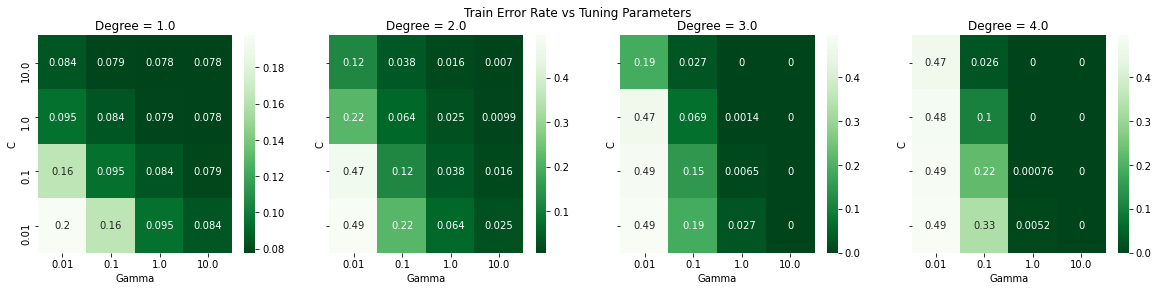

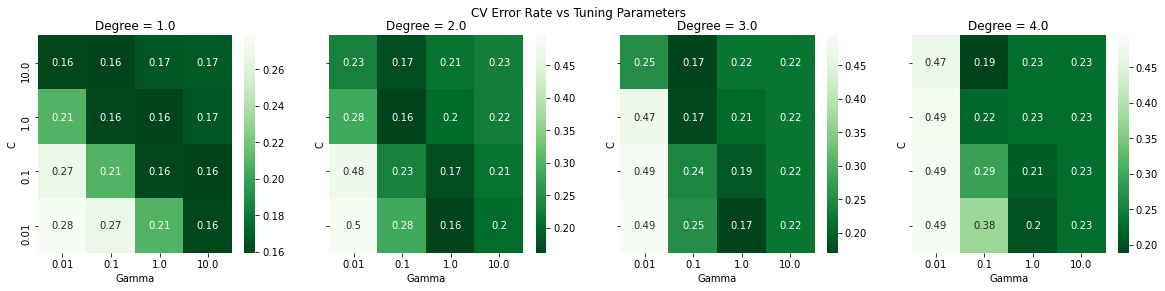

In [13]:
fig, axs = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (20, 4))
for ax, degree in zip(axs.ravel(), psvc_degree_arr):
    psvc_deg_df = psvc_df[psvc_df['param_degree'] == degree]
    psvc_deg_train_err_mat = (1 - psvc_deg_df['mean_train_score']).values.reshape(len(psvc_reg_arr), len(psvc_gamma_arr))
    ax = sns.heatmap(pd.DataFrame(psvc_deg_train_err_mat, columns = psvc_gamma_arr, index = psvc_reg_arr).iloc[::-1], 
                     ax = ax, annot = True, cmap = 'Greens_r')
    ax.set(xlabel = 'Gamma', ylabel = 'C', title = 'Degree = ' + str(degree))
fig.suptitle('Train Error Rate vs Tuning Parameters')
plt.show()

fig, axs = plt.subplots(1, 4, sharex = True, sharey = True, figsize = (20, 4))
for ax, degree in zip(axs.ravel(), psvc_degree_arr):
    psvc_deg_df = psvc_df[psvc_df['param_degree'] == degree]
    psvc_deg_cv_err_mat = (1 - psvc_deg_df['mean_test_score']).values.reshape(len(psvc_reg_arr), len(psvc_gamma_arr))
    ax = sns.heatmap(pd.DataFrame(psvc_deg_cv_err_mat, columns = psvc_gamma_arr, index = psvc_reg_arr).iloc[::-1], 
                     ax = ax, annot = True, cmap = 'Greens_r')
    ax.set(xlabel = 'Gamma', ylabel = 'C', title = 'Degree = ' + str(degree))
fig.suptitle('CV Error Rate vs Tuning Parameters')
plt.show()

Best Parameters: {'C': 1.0, 'degree': 1.0, 'gamma': 1.0}
Best Cross-Validation Accuracy: 0.84


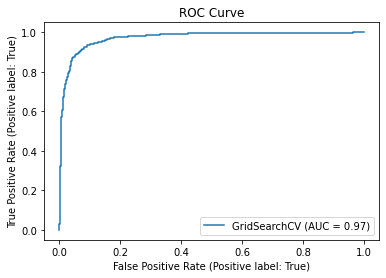

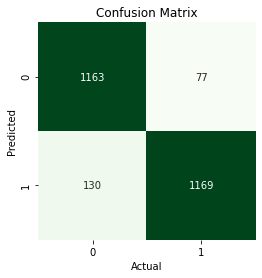

Accuracy: 0.92
Sensitivity: 0.94
Specificity: 0.90


In [14]:
print('Best Parameters: {}'.format(psvc.best_params_))
print('Best Cross-Validation Accuracy: {:.2f}'.format(psvc.best_score_))

pred_psvc = psvc.predict(X1_test)

plot_roc_curve(psvc, X1_test, c_test)
plt.title('ROC Curve')
plt.show()

cm_psvc = confusion_matrix(c_test, pred_psvc)
tn, fp, fn, tp = cm_psvc.ravel()

ax = sns.heatmap(cm_psvc.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_psvc)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

### Decision Tree Classification

In [15]:
dt_criterion = ['gini','entropy']
dt_max_depth_arr = np.linspace(1, 10, 10).astype(int)
dt_min_leaf_arr = np.linspace(1, 10, 10).astype(int)

dt = GridSearchCV(DecisionTreeClassifier(random_state = 42), 
                  param_grid = {'criterion': dt_criterion, 
                                'max_depth' : dt_max_depth_arr, 
                                'min_samples_leaf' : dt_min_leaf_arr}, 
                  cv = 5, return_train_score = True)

dt.fit(X2_train, c_train)

dt_df = pd.DataFrame(dt.cv_results_)

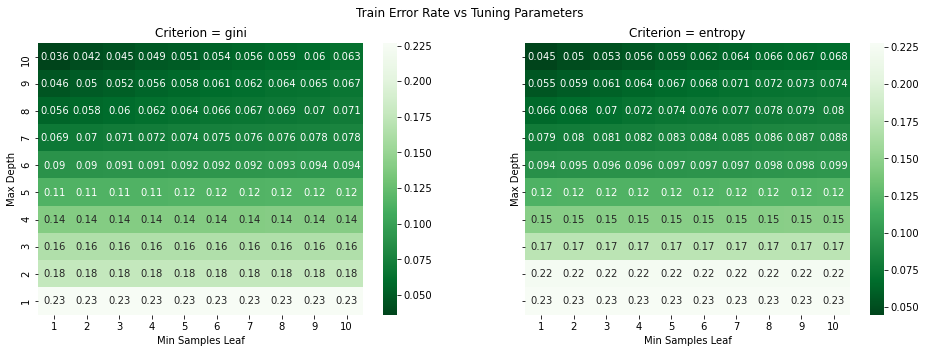

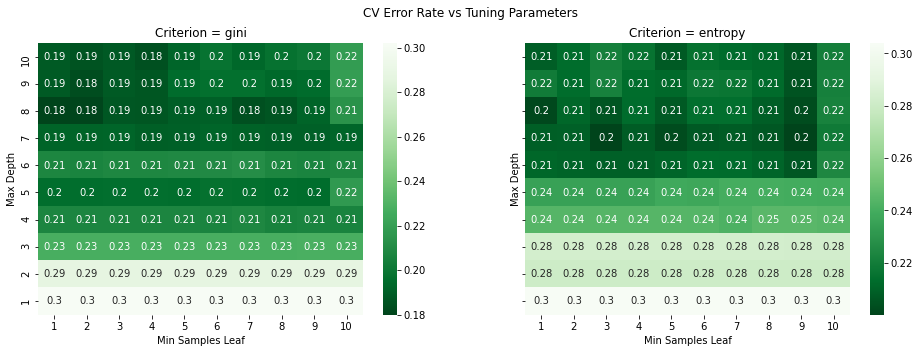

In [16]:
fig, axs = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (16, 5))
for ax, criterion in zip(axs.ravel(), dt_criterion):
    dt_criterion_df = dt_df[dt_df['param_criterion'] == criterion]
    dt_criterion_train_err_mat = (1 - dt_criterion_df['mean_train_score']).values.reshape(len(dt_max_depth_arr), 
                                                                                          len(dt_min_leaf_arr))
    ax = sns.heatmap(pd.DataFrame(dt_criterion_train_err_mat, columns = dt_min_leaf_arr, 
                                  index = dt_max_depth_arr).iloc[::-1], ax = ax, annot = True, cmap = 'Greens_r')
    ax.set(xlabel = 'Min Samples Leaf', ylabel = 'Max Depth', title = 'Criterion = ' + str(criterion))
fig.suptitle('Train Error Rate vs Tuning Parameters')
plt.show()

fig, axs = plt.subplots(1, 2, sharex = True, sharey = True, figsize = (16, 5))
for ax, criterion in zip(axs.ravel(), dt_criterion):
    dt_criterion_df = dt_df[dt_df['param_criterion'] == criterion]
    dt_criterion_cv_err_mat = (1 - dt_criterion_df['mean_test_score']).values.reshape(len(dt_max_depth_arr), 
                                                                                  len(dt_min_leaf_arr))
    ax = sns.heatmap(pd.DataFrame(dt_criterion_cv_err_mat, columns = dt_min_leaf_arr, 
                                  index = dt_max_depth_arr).iloc[::-1], ax = ax, annot = True, cmap = 'Greens_r')
    ax.set(xlabel = 'Min Samples Leaf', ylabel = 'Max Depth', title = 'Criterion = ' + str(criterion))
fig.suptitle('CV Error Rate vs Tuning Parameters')
plt.show()

Best Parameters: {'criterion': 'gini', 'max_depth': 8, 'min_samples_leaf': 1}
Best Cross-Validation Accuracy: 0.82


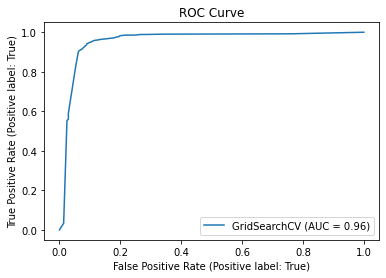

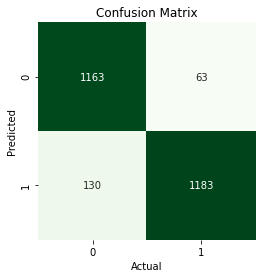

Accuracy: 0.92
Sensitivity: 0.95
Specificity: 0.90


In [17]:
print("Best Parameters: {}".format(dt.best_params_))
print("Best Cross-Validation Accuracy: {:.2f}".format(dt.best_score_))

pred_dt = dt.predict(X2_test)

plot_roc_curve(dt, X2_test, c_test)
plt.title('ROC Curve')
plt.show()

cm_dt = confusion_matrix(c_test, pred_dt)
tn, fp, fn, tp = cm_dt.ravel()

ax = sns.heatmap(cm_dt.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_dt)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

In [18]:
plot_dt = DecisionTreeClassifier(random_state = 42, criterion = dt.best_params_['criterion'], 
                                 max_depth = dt.best_params_['max_depth'], 
                                 min_samples_leaf = dt.best_params_['min_samples_leaf'])
plot_dt.fit(X2_train, c_train)

# fig = plt.figure(figsize=(25, 20))
# _ = plot_tree(plot_dt, feature_names = list(X2_train.columns), class_names = ['False', 'True'], filled = True)

print(export_text(plot_dt, feature_names = list(X2_train.columns)))

|--- temperature <= 7.35
|   |--- season:_Winter <= 0.50
|   |   |--- solar_radiation <= 0.00
|   |   |   |--- season:_Spring <= 0.50
|   |   |   |   |--- hour:_22 <= 0.50
|   |   |   |   |   |--- hour:_23 <= 0.50
|   |   |   |   |   |   |--- hour:_7 <= 0.50
|   |   |   |   |   |   |   |--- hour:_21 <= 0.50
|   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |--- hour:_21 >  0.50
|   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |--- hour:_7 >  0.50
|   |   |   |   |   |   |   |--- day:_Saturday <= 0.50
|   |   |   |   |   |   |   |   |--- class: True
|   |   |   |   |   |   |   |--- day:_Saturday >  0.50
|   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |--- hour:_23 >  0.50
|   |   |   |   |   |   |--- snowfall <= 0.20
|   |   |   |   |   |   |   |--- temperature <= 1.15
|   |   |   |   |   |   |   |   |--- class: False
|   |   |   |   |   |   |   |--- temperature >  1.15
|   |   |   |   |   |   |   |   |--- class: 

### Decision Tree Classification with Cost Complexity Pruning

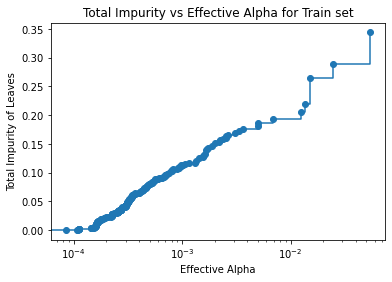

In [19]:
ccpdt = DecisionTreeClassifier(random_state = 42)
ccpdt_path = ccpdt.cost_complexity_pruning_path(X2_train, c_train)
ccpdt_alphas, ccpdt_impurities = ccpdt_path.ccp_alphas, ccpdt_path.impurities

plt.plot(ccpdt_alphas[:-1], ccpdt_impurities[:-1], marker = 'o', drawstyle = 'steps-post')
plt.xscale('log')
plt.xlabel('Effective Alpha')
plt.ylabel('Total Impurity of Leaves')
plt.title('Total Impurity vs Effective Alpha for Train set')
plt.show()

In [20]:
pdt = GridSearchCV(DecisionTreeClassifier(random_state = 42), 
                  param_grid = {'ccp_alpha': ccpdt_alphas[:-1]}, 
                  cv = 5, return_train_score = True)

pdt.fit(X2_train, c_train)

pdt_df = pd.DataFrame(pdt.cv_results_)

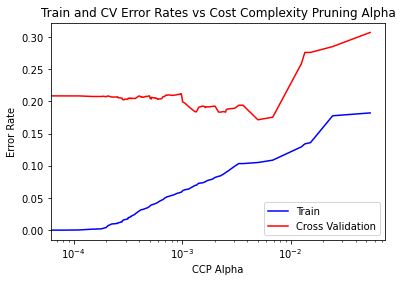

In [21]:
plt.plot(pdt_df['param_ccp_alpha'], 1 - pdt_df['mean_train_score'], c = 'b', label = 'Train')
plt.plot(pdt_df['param_ccp_alpha'], 1 - pdt_df['mean_test_score'], c = 'r', label = 'Cross Validation')
plt.xscale('log')
plt.legend(loc = 4)
plt.xlabel('CCP Alpha')
plt.ylabel('Error Rate')
plt.title('Train and CV Error Rates vs Cost Complexity Pruning Alpha')
plt.show()

Best Parameters: {'ccp_alpha': 0.004986259934294499}
Best Cross-Validation Accuracy: 0.83


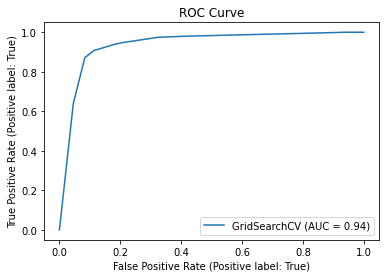

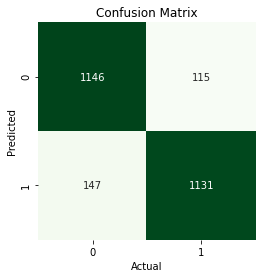

Accuracy: 0.90
Sensitivity: 0.91
Specificity: 0.89


In [22]:
print("Best Parameters: {}".format(pdt.best_params_))
print("Best Cross-Validation Accuracy: {:.2f}".format(pdt.best_score_))

pred_pdt = pdt.predict(X2_test)

plot_roc_curve(pdt, X2_test, c_test)
plt.title('ROC Curve')
plt.show()

cm_pdt = confusion_matrix(c_test, pred_pdt)
tn, fp, fn, tp = cm_pdt.ravel()

ax = sns.heatmap(cm_pdt.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_pdt)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))

### AdaBoost Decision Tree

In [23]:
adt_learning_rate_arr = np.logspace(-4, 0, 5)
adt_n_estimators_arr = [10, 20, 50, 100, 200, 500, 1000, 2000]

adt = GridSearchCV(AdaBoostClassifier(random_state = 42), 
                   param_grid = {'learning_rate' : adt_learning_rate_arr, 'n_estimators' : adt_n_estimators_arr}, 
                   cv = 5, return_train_score = True)

adt.fit(X2_train.values, c_train.values.ravel())

adt_df = pd.DataFrame(adt.cv_results_)

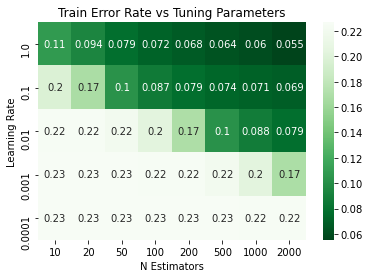

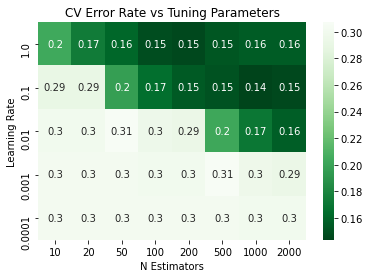

In [24]:
adt_train_err_mat = (1 - adt_df['mean_train_score']).values.reshape(len(adt_learning_rate_arr), len(adt_n_estimators_arr))
ax = sns.heatmap(pd.DataFrame(adt_train_err_mat, columns = adt_n_estimators_arr, index = adt_learning_rate_arr).iloc[::-1], 
                 annot = True, cmap = 'Greens_r')
ax.set(xlabel = 'N Estimators', ylabel = 'Learning Rate', title = 'Train Error Rate vs Tuning Parameters')
plt.show()

adt_cv_err_mat = (1 - adt_df['mean_test_score']).values.reshape(len(adt_learning_rate_arr), len(adt_n_estimators_arr))
ax = sns.heatmap(pd.DataFrame(adt_cv_err_mat, columns = adt_n_estimators_arr, index = adt_learning_rate_arr).iloc[::-1], 
                 annot = True, cmap = 'Greens_r')
ax.set(xlabel = 'N Estimators', ylabel = 'Learning Rate', title = 'CV Error Rate vs Tuning Parameters')
plt.show()

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 1000}
Best Cross-Validation Accuracy: 0.86


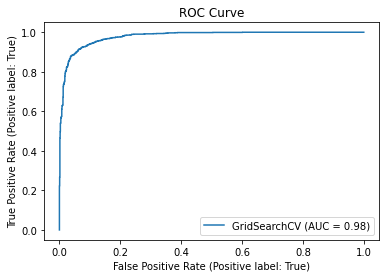

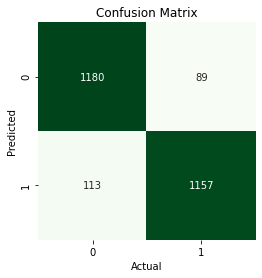

Accuracy: 0.92
Sensitivity: 0.93
Specificity: 0.91


In [25]:
print("Best Parameters: {}".format(adt.best_params_))
print("Best Cross-Validation Accuracy: {:.2f}".format(adt.best_score_))

pred_adt = adt.predict(X2_test)

plot_roc_curve(adt, X2_test, c_test)
plt.title('ROC Curve')
plt.show()

cm_adt = confusion_matrix(c_test, pred_adt)
tn, fp, fn, tp = cm_adt.ravel()

ax = sns.heatmap(cm_adt.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'Greens')
ax.set(xlabel = 'Actual', ylabel = 'Predicted', title = 'Confusion Matrix')
plt.show()

print('Accuracy: {:.2f}'.format(accuracy_score(c_test, pred_adt)))
print('Sensitivity: {:.2f}'.format(tp / (tp + fn)))
print('Specificity: {:.2f}'.format(tn / (tn + fp)))